In [1]:
import math
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms



In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST('', download=True, train=True, transform=transform)
test_data = datasets.MNIST('',download=True, train=False, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_data,(50000, 10000))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 35.8MB/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.45MB/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.68MB/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 500)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 500)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 500)

In [4]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10
criterion1 = nn.CrossEntropyLoss()

# Network with vanilla RNN cells

In [5]:
class Vanilla_RNN(nn.Module):
  def __init__(self):
    super(Vanilla_RNN, self).__init__() # RNN layer with i/p size 28, hidden size 128
    self.rnn = nn.RNN(28, 128)
    self.output_layer = nn.Linear(128, 10) # Fully connected layer

  def forward(self, inputs):
    inputs = inputs.permute(1, 0, 2) # Rearrange dimensions to match RNN i/p
    initial_hidden_state = torch.zeros(1,inputs.size(1), 128) # Initial hidden stat
    _ , last_hidden_state = self.rnn(inputs, initial_hidden_state)
    outputs = self.output_layer(last_hidden_state)
    return outputs.reshape(500, 10)

# In PyTorch, nn.RNN module expects i/p tensors in the shape (sequence_length, batch_size, input_size).
# By default, i/p data to a model is typically arranged in the format (batch_size, sequence_length, input_size).
# Hence inputs.permute(1, 0, 2): (batch_size, sequence_length, input_size) to (sequence_length, batch_size, input_size

In [6]:
# Training loop
train_losses = []
validation_losses = []
validation_accuracies = []

model1 = Vanilla_RNN()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_train_loss = 0  # To accumulate training loss for the epoch

    # Training phase
    for batch_index, (batch_images, batch_labels) in enumerate(train_loader):
        batch_images = batch_images.reshape(-1, 28, 28)
        predictions = model1(batch_images)
        loss = criterion1(predictions, batch_labels)
        train_losses.append(loss.item())
        epoch_train_loss += loss.item()  # Accumulate batch losses

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

    # Calculate average training loss for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation phase
    total_validation_loss = 0
    correct_validation_predictions = 0
    iteration_count = 0

    for batch_images, batch_labels in val_loader:
        batch_images = batch_images.reshape(-1, 28, 28)
        predictions = model1(batch_images)
        loss = criterion1(predictions, batch_labels)
        _, predicted_labels = torch.max(predictions.data, 1)
        correct_validation_predictions += (predicted_labels == batch_labels).sum().item()
        total_validation_loss += loss.item()
        iteration_count += 1

    # Calculate average validation loss and accuracy for the epoch
    avg_validation_loss = total_validation_loss / iteration_count
    validation_accuracy = correct_validation_predictions / len(val_loader.dataset) * 100

    # Append validation metrics
    validation_losses.append(avg_validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Training Loss: {avg_epoch_train_loss:.4f}, "
          f"Validation Loss: {avg_validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%")


Epoch [1/10] - Training Loss: 1.4625, Validation Loss: 1.0989, Validation Accuracy: 62.14%
Epoch [2/10] - Training Loss: 0.9127, Validation Loss: 0.7812, Validation Accuracy: 73.85%
Epoch [3/10] - Training Loss: 0.6847, Validation Loss: 0.6363, Validation Accuracy: 79.83%
Epoch [4/10] - Training Loss: 0.5513, Validation Loss: 0.6171, Validation Accuracy: 80.55%
Epoch [5/10] - Training Loss: 0.4826, Validation Loss: 0.4493, Validation Accuracy: 86.72%
Epoch [6/10] - Training Loss: 0.3947, Validation Loss: 0.3998, Validation Accuracy: 87.87%
Epoch [7/10] - Training Loss: 0.3567, Validation Loss: 0.3662, Validation Accuracy: 89.18%
Epoch [8/10] - Training Loss: 0.2999, Validation Loss: 0.3007, Validation Accuracy: 91.10%
Epoch [9/10] - Training Loss: 0.2724, Validation Loss: 0.2716, Validation Accuracy: 91.87%
Epoch [10/10] - Training Loss: 0.2538, Validation Loss: 0.2654, Validation Accuracy: 92.26%


In [7]:
def plot_training_loss(training_losses, model_name):
    plt.figure(figsize=(10, 6))
    training_iterations = np.arange(len(training_losses))
    plt.plot(training_iterations, training_losses, color='green')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.8)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('No: of Iterations')
    plt.ylabel('Training Loss')
    plt.title(f'Training Loss vs Iterations for {model_name}')
    plt.show()

In [8]:
def plot_validation_loss(validation_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', color='green')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.8)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('No: of Epochs')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss vs Epochs for {model_name}')
    plt.show()

In [9]:
def plot_validation_accuracy(validation_accuracies, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='o', color='green')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-', alpha=0.8)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('No: of Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy vs Epochs for {model_name}')
    plt.show()


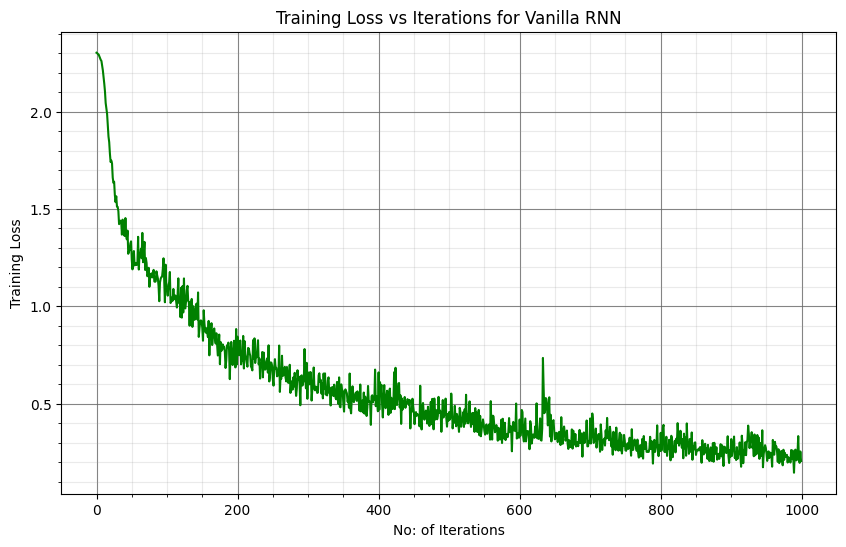

In [10]:
# For training loss
plot_training_loss(train_losses, model_name="Vanilla RNN")


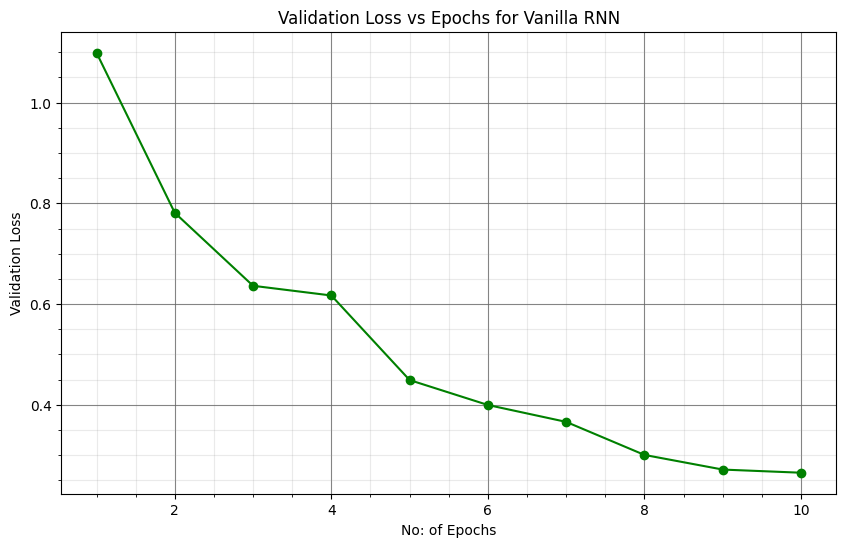

In [11]:
# For validation loss
plot_validation_loss(validation_losses, model_name="Vanilla RNN")


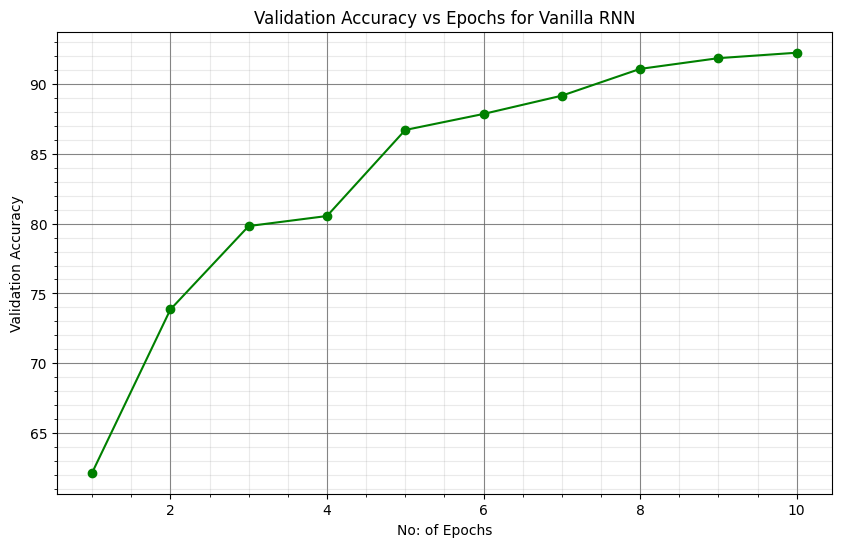

In [12]:
# For validation accuracy
plot_validation_accuracy(validation_accuracies, model_name="Vanilla RNN")

In [13]:
model1.eval() # model to evaluation mode
with torch.no_grad():   # disables gradient computation
    correct_predictions = 0
    total_samples = 0
    for test_images, test_labels in test_loader:
        test_images = test_images.reshape(-1, 28, 28)  # [sequence_length, batch_size, input_size]
        test_outputs = model1(test_images)
        _, predicted_labels = torch.max(test_outputs.data, 1) # torch.max to get the predicted class labels with the highest probability from test_outputs
        total_samples += test_labels.size(0)
        correct_predictions += (predicted_labels == test_labels).sum().item()

    print('Test Accuracy of the Vanilla RNN model: {:.3f} %'.format((correct_predictions / total_samples) * 100))


Test Accuracy of the Vanilla RNN model: 92.750 %


# Network with LSTM

In [14]:
# class LSTMClassifier(nn.Module):
#   def __init__(self):
#     super(LSTMClassifier, self).__init__()
#     self.lstm_layer = nn.LSTM(28, 128)
#     self.fc_layer = nn.Linear(128, 10) # fully connected layer

#   def forward(self, inputs):
#     h0 = torch.zeros(1, inputs.size(0), 128)  # initial hidden state
#     c0 = torch.zeros(1, inputs.size(0), 128)  # initial cell state
#     inputs = inputs.permute(1, 0, 2)
#     lstm_out, (hn, cn) = self.lstm_layer(inputs, (h0, c0)) # hn,cn:final hidden & cell states
#     output = self.fc_layer(lstm_out[27])
#     return output.reshape(500, 10)


In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=28, hidden_size=128, batch_first=True)
        self.fc_layer = nn.Linear(128, 10)  # Fully connected layer

    def forward(self, inputs):
        batch_size = inputs.size(0)  # Get the current batch size

        # Initial hidden and cell states with proper batch size
        h0 = torch.zeros(1, batch_size, 128).to(inputs.device)  # Move to the same device as inputs
        c0 = torch.zeros(1, batch_size, 128).to(inputs.device)

        # Permute input: (batch_size, seq_len, input_size)
        # Forward pass through LSTM
        lstm_out, (hn, cn) = self.lstm_layer(inputs, (h0, c0))

        # Use the output from the last time step (seq_len - 1)
        last_output = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)
        output = self.fc_layer(last_output)  # Shape: (batch_size, 10)

        return output


In [16]:
learning_rate = 0.001
num_epochs = 10
criterion2 = nn.CrossEntropyLoss()


In [17]:
training_losses = []
validation_losses = []
validation_accuracies = []

model2 = LSTMClassifier()  # Using the new LSTM model class name
optimizer_lstm = torch.optim.Adam(model2.parameters(), lr=learning_rate)

for epoch_num in range(num_epochs):
    epoch_train_loss = 0  # To accumulate training loss for the epoch

    for batch_idx, (batch_images, batch_labels) in enumerate(train_loader): # Iterate over batches of training data
        batch_images = batch_images.reshape(-1, 28, 28)  # Reshape for LSTM input
        predictions = model2(batch_images)
        train_loss = criterion2(predictions, batch_labels)
        training_losses.append(train_loss.item())
        epoch_train_loss += train_loss.item()  # Accumulate batch losses

        optimizer_lstm.zero_grad()  # Zero the gradients before backpropagation
        train_loss.backward()  # Backpropagation to compute gradients
        optimizer_lstm.step()

    # Calculate average training loss for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation evaluation
    validation_iters = 0
    total_val_loss = 0
    correct_predictions = 0

    for val_images, val_labels in val_loader:  # Iterate over batches of validation data
        val_images = val_images.reshape(-1, 28, 28)
        val_outputs = model2(val_images)
        val_loss = criterion2(val_outputs, val_labels)
        _, predicted_labels = torch.max(val_outputs.data, 1)  # Get the predicted labels
        correct_predictions += (predicted_labels == val_labels).sum().item()
        validation_iters += 1
        total_val_loss += val_loss.item()

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / validation_iters
    val_accuracy = correct_predictions / len(val_loader.dataset) * 100

    # Append metrics
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch_num + 1}/{num_epochs}] - "
          f"Training Loss: {avg_epoch_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/10] - Training Loss: 1.3057, Validation Loss: 0.4756, Validation Accuracy: 86.35%
Epoch [2/10] - Training Loss: 0.3407, Validation Loss: 0.2675, Validation Accuracy: 92.26%
Epoch [3/10] - Training Loss: 0.2222, Validation Loss: 0.2183, Validation Accuracy: 93.64%
Epoch [4/10] - Training Loss: 0.1683, Validation Loss: 0.1749, Validation Accuracy: 95.10%
Epoch [5/10] - Training Loss: 0.1407, Validation Loss: 0.1418, Validation Accuracy: 95.91%
Epoch [6/10] - Training Loss: 0.1171, Validation Loss: 0.1289, Validation Accuracy: 96.37%
Epoch [7/10] - Training Loss: 0.1039, Validation Loss: 0.1186, Validation Accuracy: 96.63%
Epoch [8/10] - Training Loss: 0.0942, Validation Loss: 0.1070, Validation Accuracy: 96.92%
Epoch [9/10] - Training Loss: 0.0872, Validation Loss: 0.1005, Validation Accuracy: 96.94%
Epoch [10/10] - Training Loss: 0.0786, Validation Loss: 0.0960, Validation Accuracy: 97.22%


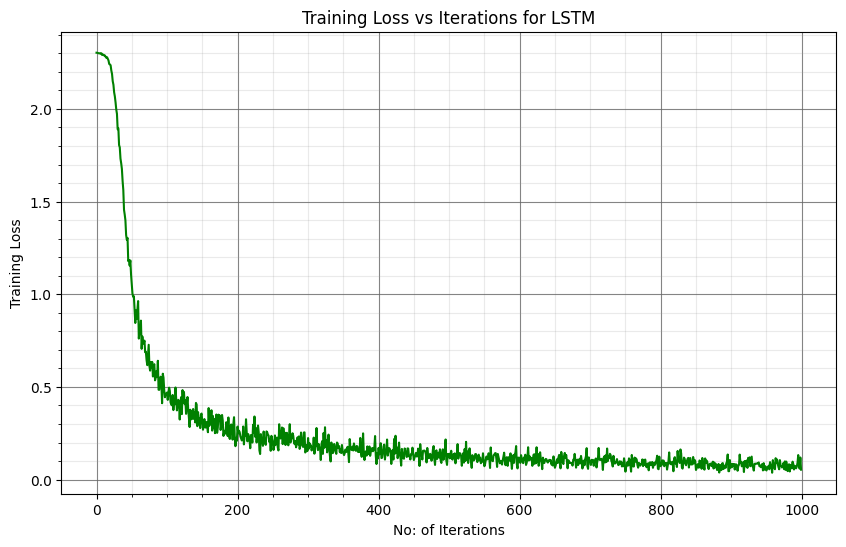

In [18]:
# For training loss
plot_training_loss(training_losses, model_name="LSTM")

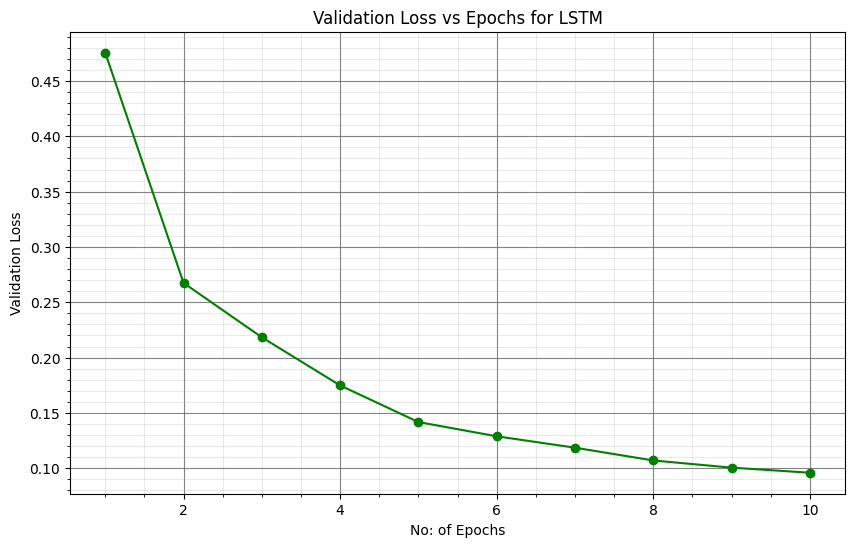

In [19]:
# For validation loss
plot_validation_loss(validation_losses, model_name="LSTM")

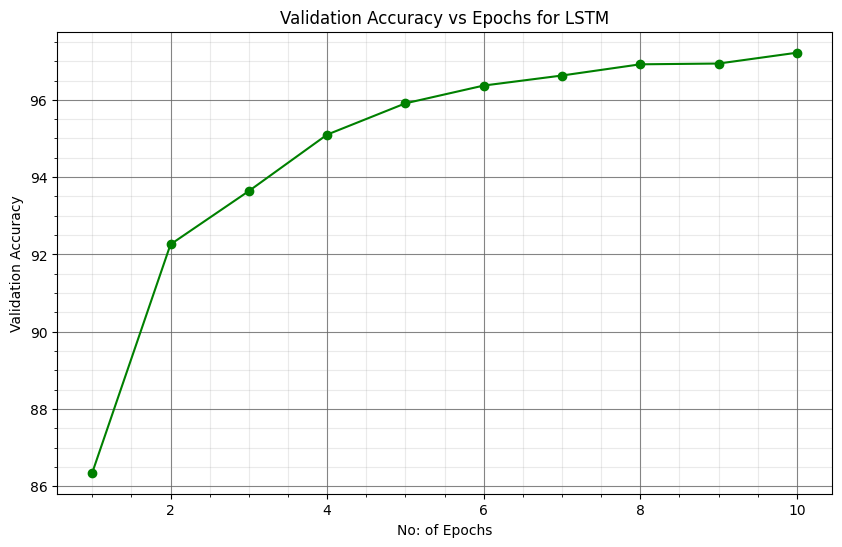

In [20]:
# For validation accuracy
plot_validation_accuracy(validation_accuracies, model_name="LSTM")

In [21]:
model2.eval()  # evaluaiton mode
with torch.no_grad():
    correct_predictions = 0
    total_samples = 0
    for test_images, test_labels in test_loader:   # Iterate over batches of test data
        test_images = test_images.reshape(-1, 28, 28)
        test_outputs = model2(test_images)
        _, predicted_labels = torch.max(test_outputs.data, 1)
        total_samples += test_labels.size(0)
        correct_predictions += (predicted_labels == test_labels).sum().item()

    print('Test Accuracy of LSTM model: {:.2f} %'.format((correct_predictions / total_samples) * 100))


Test Accuracy of LSTM model: 97.40 %


# Bidirectional RNN

In [22]:
class BiDirectionalRNN(nn.Module):
  def __init__(self):
    super(BiDirectionalRNN, self).__init__()
    self.rnn = nn.RNN(input_size=28, hidden_size=128, num_layers=1, bidirectional=True)
    self.output_layer = nn.Linear(in_features=128 * 2, out_features=10)

  def forward(self, input_data):
    input_data = input_data.permute(1, 0, 2)  # Change the shape to (sequence_length, batch_size, input_size)
    hidden_state = torch.zeros(2, input_data.size(1), 128)  # Initialize hidden state for both directions
    _, hidden_state = self.rnn(input_data, hidden_state)  # Pass the input through the RNN

    forward_hidden, backward_hidden = hidden_state[0], hidden_state[1]  # Get the hidden states from both directions
    combined_input = torch.cat((forward_hidden, backward_hidden), dim=-1)  # Concatenate the forward and backward hidden states
    output = self.output_layer(combined_input)  # Pass the concatenated hidden state to the output layer
    return output  # Return the output


In [23]:
learning_rate = 0.001
num_epochs = 10
criterion3 = nn.CrossEntropyLoss()

In [24]:
# Lists to store loss and accuracy
training_loss = []
validation_loss = []
validation_accuracy = []

model3 = BiDirectionalRNN()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_train_loss = 0  # To accumulate training loss for the epoch

    # Training phase
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28, 28)  # Reshape for RNN input
        outputs = model3(images)
        loss = criterion3(outputs, labels)
        training_loss.append(loss.item())
        epoch_train_loss += loss.item()  # Accumulate batch losses

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

    # Calculate average training loss for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation phase
    tempval_loss = 0
    correct_val = 0
    iteration = 0

    for images, labels in val_loader:
        images = images.reshape(-1, 28, 28)
        outputs = model3(images)
        loss = criterion3(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct_val += (predicted == labels).sum().item()
        tempval_loss += loss.item()
        iteration += 1

    # Calculate average validation loss and accuracy for the epoch
    avg_validation_loss = tempval_loss / iteration
    validation_acc = correct_val / len(val_loader.dataset) * 100

    # Append validation metrics
    validation_loss.append(avg_validation_loss)
    validation_accuracy.append(validation_acc)

    # Print epoch summary with training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Training Loss: {avg_epoch_train_loss:.4f}, "
          f"Validation Loss: {avg_validation_loss:.4f}, "
          f"Validation Accuracy: {validation_acc:.2f}%")


Epoch [1/10] - Training Loss: 1.2117, Validation Loss: 0.7582, Validation Accuracy: 76.05%
Epoch [2/10] - Training Loss: 0.5774, Validation Loss: 0.4582, Validation Accuracy: 86.50%
Epoch [3/10] - Training Loss: 0.3777, Validation Loss: 0.3348, Validation Accuracy: 90.20%
Epoch [4/10] - Training Loss: 0.2922, Validation Loss: 0.2722, Validation Accuracy: 92.08%
Epoch [5/10] - Training Loss: 0.2491, Validation Loss: 0.2307, Validation Accuracy: 93.39%
Epoch [6/10] - Training Loss: 0.2249, Validation Loss: 0.2128, Validation Accuracy: 93.96%
Epoch [7/10] - Training Loss: 0.1919, Validation Loss: 0.1826, Validation Accuracy: 95.09%
Epoch [8/10] - Training Loss: 0.1732, Validation Loss: 0.1738, Validation Accuracy: 95.26%
Epoch [9/10] - Training Loss: 0.1597, Validation Loss: 0.1712, Validation Accuracy: 95.22%
Epoch [10/10] - Training Loss: 0.1457, Validation Loss: 0.1684, Validation Accuracy: 95.08%


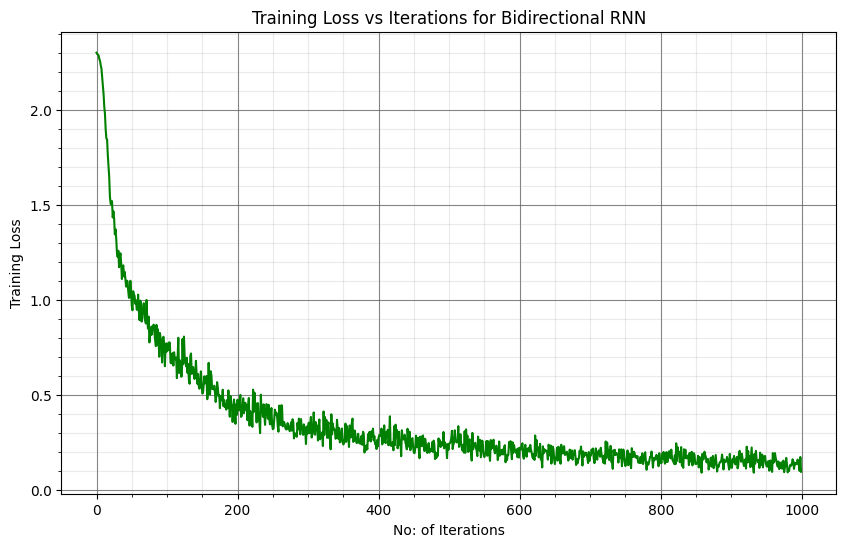

In [25]:
# For training loss
plot_training_loss(training_loss, model_name="Bidirectional RNN")

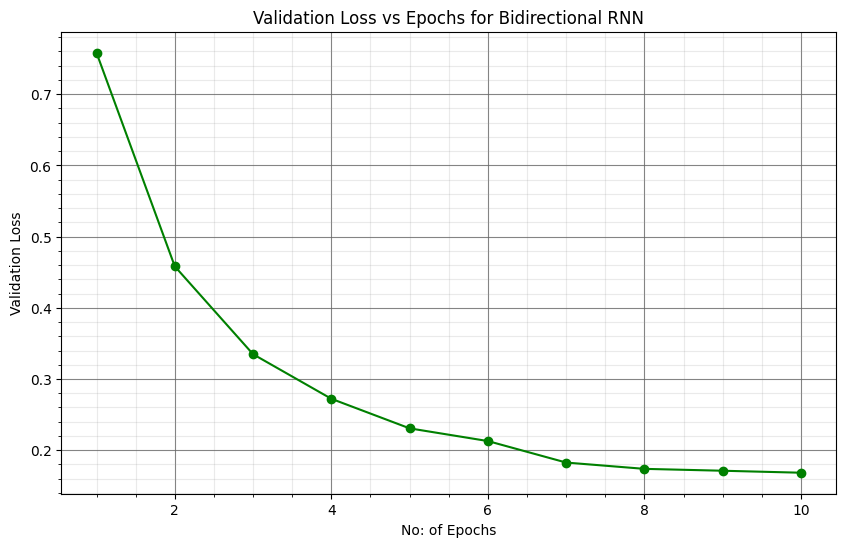

In [26]:
# For validation loss
plot_validation_loss(validation_loss, model_name="Bidirectional RNN")

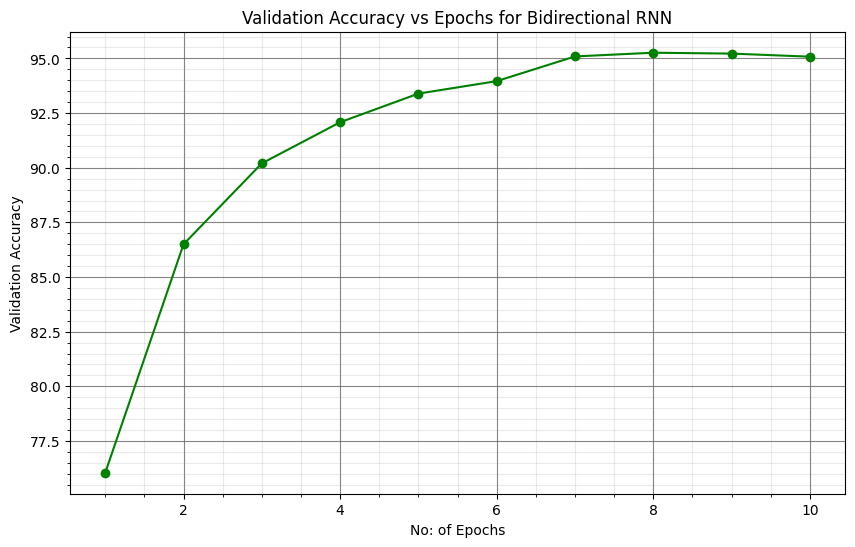

In [27]:
# For validation accuracy
plot_validation_accuracy(validation_accuracy, model_name="Bidirectional RNN")

In [28]:
model3.eval()
with torch.no_grad():
    correct_predictions = 0
    total_samples = 0
    for test_images, test_labels in test_loader:
      # print(images.shape)
      test_images = test_images.reshape(-1, 28, 28)
      test_outputs = model3(test_images)
      _, predicted_labels = torch.max(test_outputs.data, 1)
      total_samples += test_labels.size(0)
      correct_predictions += (predicted_labels == test_labels).sum().item()

    print('Test Accuracy of Bidirectional RNN model: {} %'.format((correct_predictions / total_samples) * 100))

Test Accuracy of Bidirectional RNN model: 95.52000000000001 %


Image 0 - Probability Distribution: [1.3154271e-04 2.3861825e-04 3.1932109e-04 2.2325266e-06 1.3385200e-03
 1.5034445e-04 9.9773681e-01 4.7907002e-07 7.2018171e-05 1.0122235e-05]
Image 4 - Probability Distribution: [3.58671969e-05 4.47018137e-05 1.46949715e-05 7.67895777e-04
 3.29597469e-06 1.52475783e-04 1.58596667e-05 4.46069544e-06
 9.98766541e-01 1.94129927e-04]
Image 0 - Probability Distribution: [1.3154271e-04 2.3861825e-04 3.1932109e-04 2.2325266e-06 1.3385200e-03
 1.5034445e-04 9.9773681e-01 4.7907002e-07 7.2018171e-05 1.0122235e-05]
Image 3 - Probability Distribution: [8.0636019e-06 9.9851543e-01 6.7845409e-05 7.6648750e-05 2.5530902e-04
 1.0270411e-04 4.1958294e-05 6.0913368e-04 1.5172156e-04 1.7120739e-04]
Image 4 - Probability Distribution: [3.58671969e-05 4.47018137e-05 1.46949715e-05 7.67895777e-04
 3.29597469e-06 1.52475783e-04 1.58596667e-05 4.46069544e-06
 9.98766541e-01 1.94129927e-04]


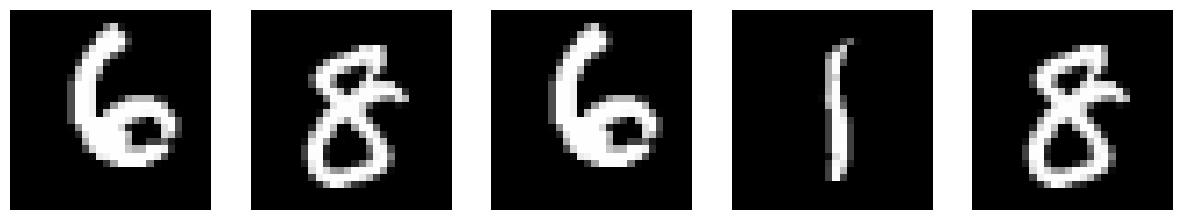

Predicted labels: [6. 8. 6. 1. 8.]
Actual labels: [6. 8. 6. 1. 8.]


In [29]:
# plotting predicted and actual labels
subplot_index = 1
selected_indices = (5 * np.abs(np.random.rand(5))).astype(int)
predicted = np.zeros(5)
true_labels = np.zeros(5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Loop through each subplot
for idx in range(5):
    ax = axes[idx]  # Access the individual axes

    ax.set_xticks([]) # Remove all axis ticks and labels
    ax.set_yticks([])

    # Remove the spines (the borders of the image)
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.imshow(images[selected_indices[idx]], cmap='gray')
    ax.axis('off')

    # Prediction and label extraction
    output = model2(images)  # Get raw logits for the entire batch
    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)

    # Extract the probability distribution for the selected image
    prob_distribution = probabilities[selected_indices[idx]].detach().cpu().numpy()  # Detach before converting to NumPy

    # Print probabilities for this image
    print(f"Image {selected_indices[idx]} - Probability Distribution: {prob_distribution}")

    # Get the predicted class with the highest probability
    _, model_prediction = torch.max(output[selected_indices[idx]], 0)
    predicted[idx] = model_prediction.item()
    true_labels[idx] = labels[selected_indices[idx]]

plt.show()

# Print predictions and actual labels
print('Predicted labels:', predicted)
print('Actual labels:', true_labels)


In [30]:
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')


Mounted at /content/drive


In [31]:
# Save the model's state dictionary
torch.save(model2.state_dict(), '/content/drive/MyDrive/PhD/SEM_2/DL/LAB/LAB4/lstm_model.pth')

<ipython-input-32-1d3b0dd5d261>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('/content/drive/MyDrive/PhD/SEM_2/DL/LAB/LAB4/lstm_mo

Raw output for image 0: tensor([[-1.4608, -1.4952, -3.3222,  2.7312, -3.1763,  1.0982, -4.5947,  2.0181,
          1.4472,  4.4635]])
Raw output for image 1: tensor([[-1.4047, -1.5026, -3.3442,  2.7520, -3.1818,  1.1274, -4.5827,  1.9630,
          1.4722,  4.5063]])
Raw output for image 2: tensor([[-1.4531, -1.5535, -3.3077,  2.7489, -3.1962,  1.1324, -4.6181,  2.0524,
          1.4196,  4.4402]])
Raw output for image 3: tensor([[-1.4281, -1.5037, -3.3362,  2.7332, -3.1817,  1.1120, -4.5751,  1.9683,
          1.4917,  4.4965]])
Raw output for image 4: tensor([[-1.2810, -1.6746, -3.3869,  2.7809, -3.1986,  1.1849, -4.4916,  1.7060,
          1.6954,  4.7254]])
Raw output for image 5: tensor([[-1.4803, -1.5964, -3.3515,  2.7272, -3.1802,  1.1530, -4.5930,  1.9641,
          1.5146,  4.5319]])
Raw output for image 6: tensor([[-1.6854, -1.8815, -3.3646,  2.6307, -3.0700,  1.0830, -4.6287,  1.9507,
          1.6068,  4.6933]])
Raw output for image 7: tensor([[-1.4374, -1.4494, -3.3212,  2

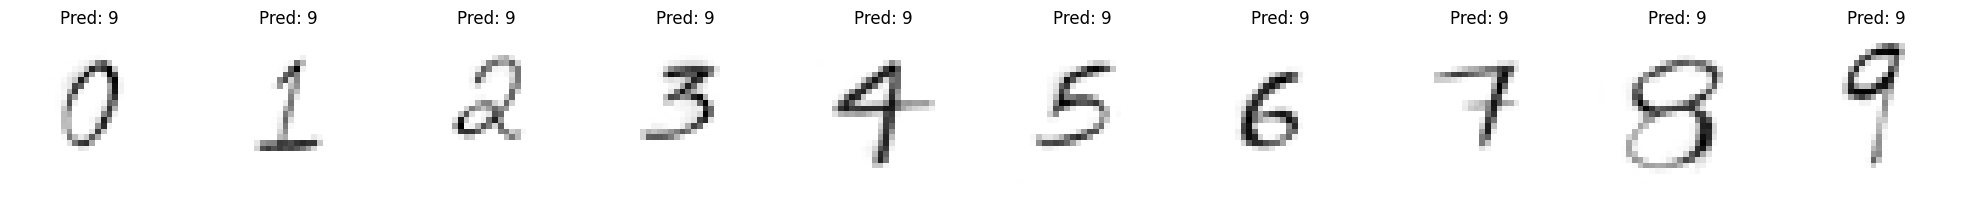

In [32]:
# Define the path to your images folder
image_folder_path = '/content/drive/MyDrive/PhD/SEM_2/DL/LAB/LAB4/custom_images/'

# Function to preprocess the images to match MNIST format
def preprocess_image(image_path):
    # Open the image, convert to grayscale, and resize to 28x28
    image = Image.open(image_path).convert('L').resize((28, 28))

    # Apply transformations: convert to tensor and normalize (MNIST pixel values are between 0 and 1)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to (C, H, W) with values between 0 and 1
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize to match the MNIST data distribution
    ])

    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension: (1, 1, 28, 28)
    return image_tensor

# List of image paths (assuming they are named 0.png to 9.png)
custom_image_paths = [f'{image_folder_path}{i}.png' for i in range(10)]

# Visualize and Predict with the Best Model
best_model = LSTMClassifier()  # Replace with your best model (LSTM, bidirectional RNN, etc.)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/PhD/SEM_2/DL/LAB/LAB4/lstm_model.pth'))
best_model.eval()

# Create a figure with subplots arranged in a single row
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # 10 images in a row

for i, image_path in enumerate(custom_image_paths):
    image_tensor = preprocess_image(image_path)

    # Predict using the model
    with torch.no_grad():
        output = best_model(image_tensor.reshape(-1, 28, 28))  # i/p shape (seq_len, batch_size, input_size)

        # Debugging: Print raw output to check if it's diverse
        print(f'Raw output for image {i}: {output}')

        _, prediction = torch.max(output, 1)

    # Display image and prediction on the corresponding axis
    axes[i].imshow(image_tensor.squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {prediction.item()}')
    axes[i].axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout to make sure images fit
plt.show()


# Adding two binary strings

In [33]:
# Data preparation
def binary_pair_generator(bit_length):
    num1 = np.random.randint(0, 2**(bit_length - 1)) # Generate two random integers with (bit_length-1) bits
    num2 = np.random.randint(0, 2**(bit_length - 1))

    sum_num = num1 + num2  # Calculate the sum

    bin_length = bit_length  # Set the bit length for the binary representations

    # Initialize arrays for storing the binary representations
    bin_num1 = np.zeros((1, bin_length))
    bin_num2 = np.zeros((1, bin_length))
    bin_sum = np.zeros((bin_length))

    # Convert num1 to binary, flip it, and store it in bin_num1
    bin_rep1 = np.flip(np.array(list(np.binary_repr(num1)), dtype=int))
    bin_num1[0][0:len(bin_rep1)] = bin_rep1[0:]

    # Convert num2 to binary, flip it, and store it in bin_num2
    bin_rep2 = np.flip(np.array(list(np.binary_repr(num2)), dtype=int))
    bin_num2[0][0:len(bin_rep2)] = bin_rep2[0:]

    # Convert sum_num to binary, flip it, and store it in bin_sum
    bin_rep_sum = np.flip(np.array(list(np.binary_repr(sum_num)), dtype=int))
    bin_sum[0:len(bin_rep_sum)] = bin_rep_sum[0:]

    # Return the concatenated binary representations of num1 and num2, along with the binary sum
    return np.concatenate((np.transpose(bin_num1), np.transpose(bin_num2)), axis=1), bin_sum


In [34]:
# generate a dataset for training, validation, and testing
train_inputs = []
train_labels = []
for i in range(250): # set of 250 samples for training
    bit_len = np.random.randint(1, 21)
    input_data, label_data = binary_pair_generator(bit_len)
    train_inputs.append(input_data)
    train_labels.append(label_data)

val_inputs = []
val_labels = []
for i in range(100): # set of 100 samples for validation
    bit_len = np.random.randint(1, 21)
    input_data, label_data = binary_pair_generator(bit_len)
    val_inputs.append(input_data)
    val_labels.append(label_data)

test_inputs = []
test_labels = []
for j in range(1, 21): # bit lengths from 1 to 20
    for i in range(100):   #  # For each bit length, it generates 100 samples: 20x100 = 1000 test samples
        input_data, label_data = binary_pair_generator(j)
        test_inputs.append(input_data)
        test_labels.append(label_data)


In [35]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(2, hidden_size)
    self.layer2 = nn.Sequential(
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

  def forward(self, X):
    X = X.permute(1, 0, 2)  # Change from (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
    hidden_state = torch.zeros(1, X.size(1), self.hidden_size)
    cell_state = torch.zeros(1, X.size(1), self.hidden_size)
    lstm_output, (hidden_state_last, cell_state_last) = self.lstm(X, (hidden_state, cell_state))
    lstm_output = self.layer2(lstm_output)
    return lstm_output.reshape(X.size(0))


In [36]:
learning_rate = 0.1
epochs = 5
loss_function = nn.MSELoss()

# Model with input feature 3
model_input_3 = LSTM(3)
optimizer_model_3 = torch.optim.Adam(model_input_3.parameters(), lr=learning_rate)

# Model with input feature 10
model_input_10 = LSTM(10)
optimizer_model_10 = torch.optim.Adam(model_input_10.parameters(), lr=learning_rate)
# 3 & 5 : number of input features the LSTM expects

In [37]:
train_loss_3 = []
val_loss_3 = []
val_accuracy_3 = []

for epoch in range(epochs):
    # Training loop
    for i in range(int(len(train_inputs))):
        input_tensor = torch.zeros((1, train_inputs[i].shape[0], train_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(train_inputs[i])

        # Forward pass
        output = model_input_3(input_tensor.float())
        label = torch.tensor(np.transpose(train_labels[i]))

        # Compute loss
        loss = loss_function(output, label.float())
        train_loss_3.append(loss.item())

        # Backward pass and optimization
        optimizer_model_3.zero_grad()
        loss.backward()
        optimizer_model_3.step()

    # Validation loop
    iteration = 0
    temp_val_loss = 0
    correct_val = 0

    for i in range(len(val_inputs)):
        input_tensor = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(val_inputs[i])

        # Forward pass
        output = model_input_3(input_tensor.float())
        label = torch.tensor(np.transpose(val_labels[i]))

        # Compute loss
        loss = loss_function(output, label.float())
        iteration += 1
        temp_val_loss += loss.item()

        # Prediction
        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0

        # Calculate accuracy
        correct_val += (predicted == label.float()).sum().item() / len(label)

    # Calculate validation accuracy and loss
    val_accuracy_3.append(100 * correct_val / iteration)
    val_loss_3.append(temp_val_loss / iteration)

    # Print statistics
    print(f'Epoch [{epoch + 1}/{epochs}] : Train Loss = {sum(train_loss_3)/len(train_loss_3):.4f}, '
          f'Validation Loss = {temp_val_loss/iteration:.4f}, '
          f'Validation Accuracy = {100 * correct_val / iteration:.2f}%')


Epoch [1/5] : Train Loss = 0.2241, Validation Loss = 0.1902, Validation Accuracy = 76.59%
Epoch [2/5] : Train Loss = 0.1773, Validation Loss = 0.0767, Validation Accuracy = 92.24%
Epoch [3/5] : Train Loss = 0.1493, Validation Loss = 0.0880, Validation Accuracy = 86.74%
Epoch [4/5] : Train Loss = 0.1336, Validation Loss = 0.0810, Validation Accuracy = 88.15%
Epoch [5/5] : Train Loss = 0.1242, Validation Loss = 0.0617, Validation Accuracy = 92.89%


In [38]:
train_loss_10 = []
val_loss_10 = []
val_accuracy_10 = []

for epoch in range(epochs):
    # Training loop
    for i in range(len(train_inputs)):
        input_tensor = torch.zeros((1, train_inputs[i].shape[0], train_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(train_inputs[i])

        # Forward pass
        output = model_input_10(input_tensor.float())
        label = torch.tensor(np.transpose(train_labels[i]))

        # Compute loss
        loss = loss_function(output, label.float())
        train_loss_10.append(loss.item())

        # Backward pass and optimization
        optimizer_model_10.zero_grad()
        loss.backward()
        optimizer_model_10.step()

    # Validation loop
    iteration = 0
    temp_val_loss = 0
    correct_val = 0

    for i in range(len(val_inputs)):
        input_tensor = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(val_inputs[i])

        # Forward pass
        output = model_input_10(input_tensor.float())
        label = torch.tensor(np.transpose(val_labels[i]))

        # Compute loss
        loss = loss_function(output, label.float())
        iteration += 1
        temp_val_loss += loss.item()

        # Prediction
        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0

        # Calculate accuracy
        correct_val += (predicted == label.float()).sum().item() / len(label)

    # Calculate validation accuracy and loss
    val_accuracy_10.append(100 * correct_val / iteration)
    val_loss_10.append(temp_val_loss / iteration)

    # Print statistics
    print(f'Epoch [{epoch + 1}/{epochs}] : Train Loss = {sum(train_loss_10)/len(train_loss_10):.4f}, '
          f'Validation Loss = {temp_val_loss/iteration:.4f}, '
          f'Validation Accuracy = {100 * correct_val / iteration:.2f}%')


Epoch [1/5] : Train Loss = 0.1985, Validation Loss = 0.1027, Validation Accuracy = 85.71%
Epoch [2/5] : Train Loss = 0.1127, Validation Loss = 0.0015, Validation Accuracy = 100.00%
Epoch [3/5] : Train Loss = 0.0754, Validation Loss = 0.0006, Validation Accuracy = 100.00%
Epoch [4/5] : Train Loss = 0.0567, Validation Loss = 0.0003, Validation Accuracy = 100.00%
Epoch [5/5] : Train Loss = 0.0454, Validation Loss = 0.0002, Validation Accuracy = 100.00%


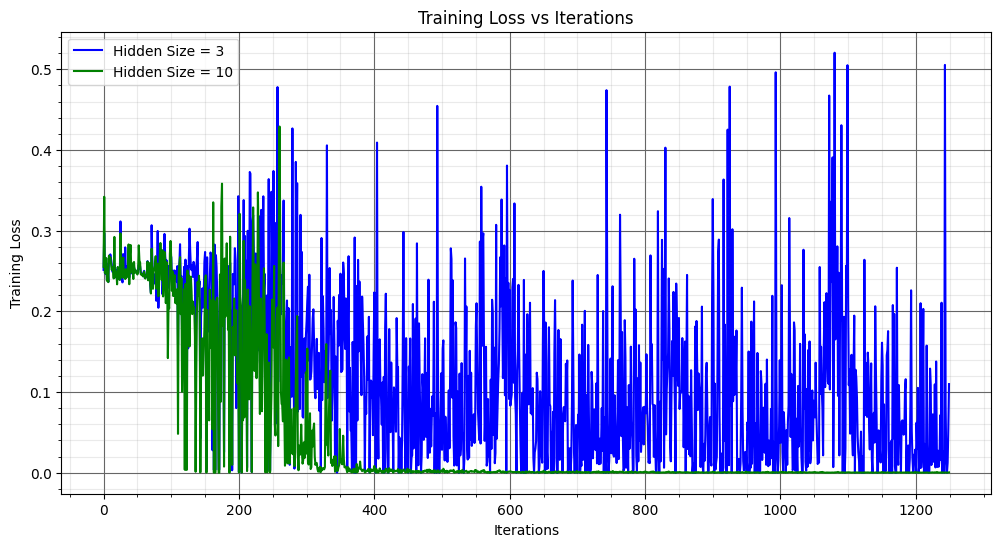

In [39]:
# Training Loss vs Iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
x_train_loss = np.arange(len(train_loss_3))
plt.plot(x_train_loss, train_loss_3, label="Hidden Size = 3", color='b')  # Blue
plt.plot(x_train_loss, train_loss_10, label="Hidden Size = 10", color='g')  # Green
plt.grid( which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

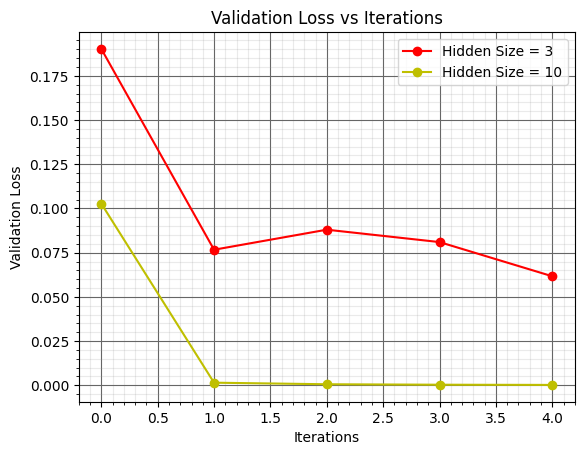

In [40]:
# Validation Loss vs Iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
x_val_loss = np.arange(len(val_loss_3))
plt.plot(x_val_loss, val_loss_3, label="Hidden Size = 3", marker='o', color='r')
plt.plot(x_val_loss, val_loss_10, label="Hidden Size = 10", marker='o', color='y')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

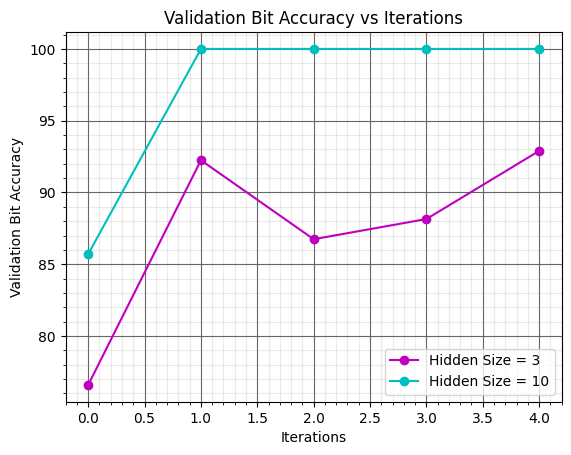

In [41]:
# Validation Bit Accuracy vs Iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
x_val_acc = np.arange(len(val_accuracy_3))
plt.plot(x_val_acc, val_accuracy_3, label="Hidden Size = 3", marker='o', color='m')
plt.plot(x_val_acc, val_accuracy_10, label="Hidden Size = 10", marker='o', color='c')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Bit Accuracy')
plt.title('Validation Bit Accuracy vs Iterations')
plt.legend()
plt.show()


In [42]:
# Set the model to evaluation mode
model_input_3.eval()
correct_accuracy_3 = np.zeros(20)  # Correct accuracy array for hidden size = 3

# Perform inference without gradient computation
with torch.no_grad():
    for i in range(len(test_inputs)):
        a = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        a[0] = torch.from_numpy(test_inputs[i])
        output = model_input_3 (a.float())
        label = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0
        correct_accuracy_3[len(label) - 1] += (predicted == label.float()).sum().item() / len(label)

# accuracy for hidden size = 3
print('Accuracy for hidden states = 3:', (np.sum(correct_accuracy_3) / 20))


Accuracy for hidden states = 3: 92.82705194165138


In [43]:
# Set the second model to evaluation mode
model_input_10.eval()
correct_accuracy_10 = np.zeros(20)  # Correct accuracy array for hidden size = 10

# Perform inference without gradient computation
with torch.no_grad():
    for i in range(len(test_inputs)):  # test_X → test_data_X
        a = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        a[0] = torch.from_numpy(test_inputs[i])
        output = model_input_10(a.float())  # model5_10 → model_10_hidden
        label = torch.tensor(np.transpose(test_labels[i]))  # test_Y → test_data_Y
        predicted = torch.zeros(output.shape)
        predicted[output > 0.5] = 1
        predicted[output <= 0.5] = 0
        correct_accuracy_10[len(label) - 1] += (predicted == label.float()).sum().item() / len(label)

# accuracy for hidden size = 10
print('Accuracy for hidden states = 10:', (np.sum(correct_accuracy_10) / 20))

Accuracy for hidden states = 10: 100.0


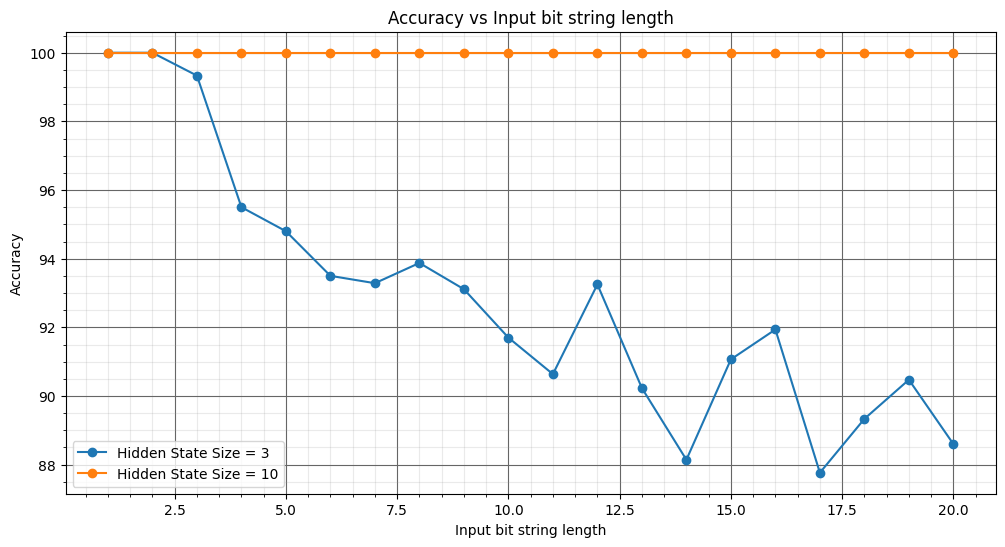

In [44]:
bit_length_range = np.arange(1, 21)

# Plot the accuracy vs bit string length for both hidden state sizes
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)

# Plot for the model with hidden state size 3
plt.plot(bit_length_range, correct_accuracy_3, label="Hidden State Size = 3", marker='o')

# Plot for the model with hidden state size 10
plt.plot(bit_length_range, correct_accuracy_10, label="Hidden State Size = 10", marker='o')

plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input bit string length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input bit string length')
plt.legend()
plt.show()


In [45]:
learning_rate_new = 0.08
num_epochs = 5

loss_function = nn.MSELoss()

# Initializing models with different hidden state sizes for more variety
model_5_mse = LSTM(5)  # Model with 8 hidden units for MSE task
model_5_ce = LSTM(5)  # Model with 8 hidden units for Cross-Entropy task

# Optimizers for the models
optimizer_mse_model = torch.optim.Adam(model_5_mse.parameters(), lr=learning_rate_new)
optimizer_ce_model = torch.optim.Adam(model_5_ce.parameters(), lr=learning_rate_new)


In [46]:
train_loss_5_mse = []
val_loss_5_mse = []
val_acc_5_mse = []

for epoch in range(num_epochs):
    # Training loop
    for i in range(len(train_inputs)):
        input_data = torch.tensor(train_inputs[i]).unsqueeze(0).float()
        true_label = torch.tensor(np.transpose(train_labels[i])).float()

        # Forward pass
        output = model_5_mse(input_data)

        # Compute loss
        loss = loss_function(output, true_label)
        train_loss_5_mse.append(loss.item())

        # Backpropagation
        optimizer_mse_model.zero_grad()
        loss.backward()
        optimizer_mse_model.step()

    # Validation loop
    temp_val_loss = 0
    correct_val = 0
    iteration = 0

    for i in range(len(val_inputs)):
        input_data = torch.tensor(val_inputs[i]).unsqueeze(0).float()
        true_label = torch.tensor(np.transpose(val_labels[i])).float()

        # Forward pass
        output = model_5_mse(input_data)

        # Compute loss
        loss = loss_function(output, true_label)
        temp_val_loss += loss.item()
        iteration += 1

        # Make predictions
        predicted = (output >= 0.5).float()

        # Calculate accuracy
        correct_val += (predicted == true_label).sum().item()

    # Append validation results
    val_loss_5_mse.append(temp_val_loss / iteration)
    val_acc_5_mse.append(100 * correct_val / (len(val_inputs) * len(val_labels[0])))  # Total accuracy

    # Print training and validation information
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Training Loss: {np.mean(train_loss_5_mse):.4f}, "
          f"Validation Loss: {np.mean(val_loss_5_mse):.4f}, "
          f"Validation Accuracy: {np.mean(val_acc_5_mse):.2f}%")


Epoch [1/5] - Training Loss: 0.2304, Validation Loss: 0.1981, Validation Accuracy: 49.00%
Epoch [2/5] - Training Loss: 0.1862, Validation Loss: 0.1384, Validation Accuracy: 57.00%
Epoch [3/5] - Training Loss: 0.1468, Validation Loss: 0.1130, Validation Accuracy: 60.11%
Epoch [4/5] - Training Loss: 0.1260, Validation Loss: 0.0996, Validation Accuracy: 61.67%
Epoch [5/5] - Training Loss: 0.1135, Validation Loss: 0.0910, Validation Accuracy: 62.60%


In [47]:
criterion_ce = nn.CrossEntropyLoss()

train_loss_5_ce = []
val_loss_5_ce = []
val_acc_5_ce = []

for epoch in range(num_epochs):
    epoch_train_loss = 0  # To accumulate the training loss for each epoch
    epoch_val_loss = 0    # To accumulate the validation loss for each epoch
    epoch_correct = 0     # To accumulate the correct predictions for validation accuracy

    for i in range(int(len(train_inputs))):
        input_data = torch.zeros((1, train_inputs[i].shape[0], train_inputs[i].shape[1]))
        input_data[0] = torch.from_numpy(train_inputs[i])
        output = model_5_ce(input_data.float())
        true_label = torch.tensor(np.transpose(train_labels[i]))

        loss = criterion_ce(output, true_label.float())
        train_loss_5_ce.append(loss.item())
        epoch_train_loss += loss.item()  # Accumulate training loss

        optimizer_ce_model.zero_grad()
        loss.backward()
        optimizer_ce_model.step()

    iteration = 0
    temp_val_loss = 0
    correct_val = 0

    for i in range(len(val_inputs)):
        correct = 0
        input_data = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_data[0] = torch.from_numpy(val_inputs[i])
        output = model_5_ce(input_data.float())
        true_label = torch.tensor(np.transpose(val_labels[i]))

        loss = criterion_ce(output, true_label.float())
        iteration += 1
        temp_val_loss += loss.item()

        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0
        correct += (predicted == true_label.float()).sum().item() / len(true_label)

    val_acc_5_ce.append(100 * correct / iteration)
    val_loss_5_ce.append(temp_val_loss / iteration)

    # Print the metrics after each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] : Training Loss: {epoch_train_loss / len(train_inputs):.4f}, '
          f'Validation Loss: {temp_val_loss / iteration:.4f}, '
          f'Validation Accuracy: {100 * correct / iteration:.2f}%')


Epoch [1/5] : Training Loss: 13.5005, Validation Loss: 14.8607, Validation Accuracy: 0.54%
Epoch [2/5] : Training Loss: 12.8122, Validation Loss: 12.9654, Validation Accuracy: 1.00%
Epoch [3/5] : Training Loss: 12.5170, Validation Loss: 12.9576, Validation Accuracy: 1.00%
Epoch [4/5] : Training Loss: 12.5128, Validation Loss: 12.9555, Validation Accuracy: 1.00%
Epoch [5/5] : Training Loss: 12.5114, Validation Loss: 12.9545, Validation Accuracy: 1.00%


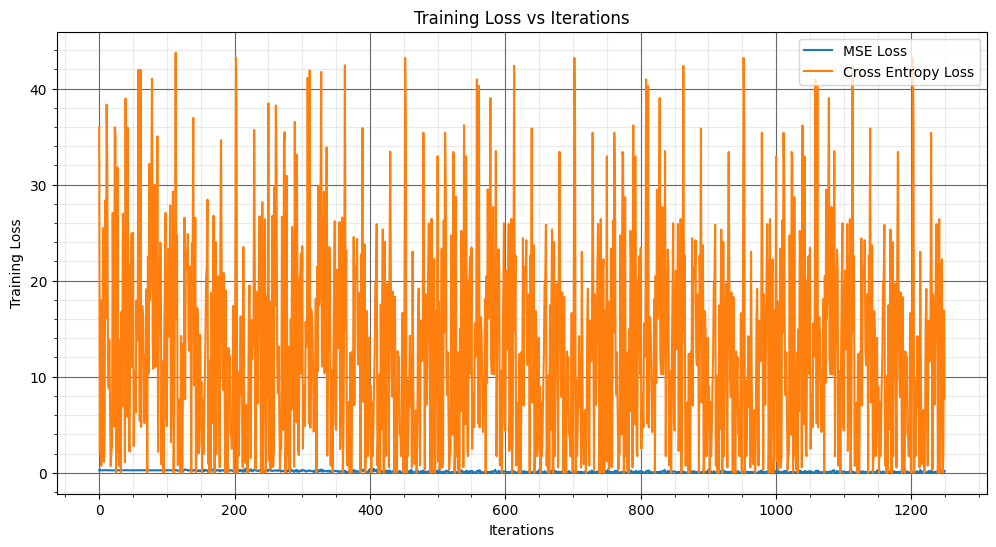

In [48]:
# Plotting training loss vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
x_train_loss = np.arange(len(train_loss_5_mse))
plt.plot(x_train_loss, train_loss_5_mse, label="MSE Loss", color='tab:blue')
plt.plot(x_train_loss, train_loss_5_ce, label="Cross Entropy Loss", color='tab:orange')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

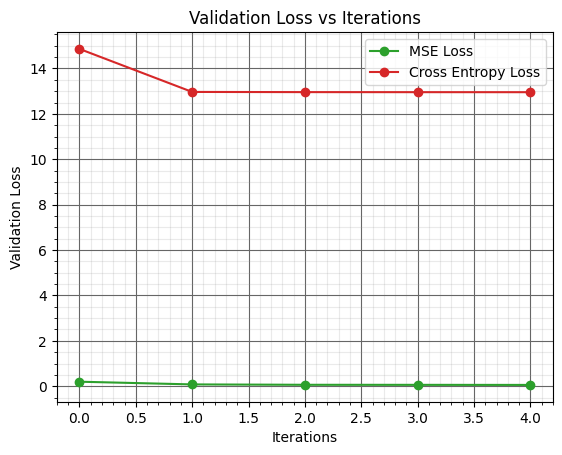

In [49]:
# Plotting validation loss vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
x_val_loss = np.arange(len(val_loss_5_mse))
plt.plot(x_val_loss, val_loss_5_mse, label="MSE Loss", color='tab:green', marker='o')
plt.plot(x_val_loss, val_loss_5_ce, label="Cross Entropy Loss", color='tab:red', marker='o')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

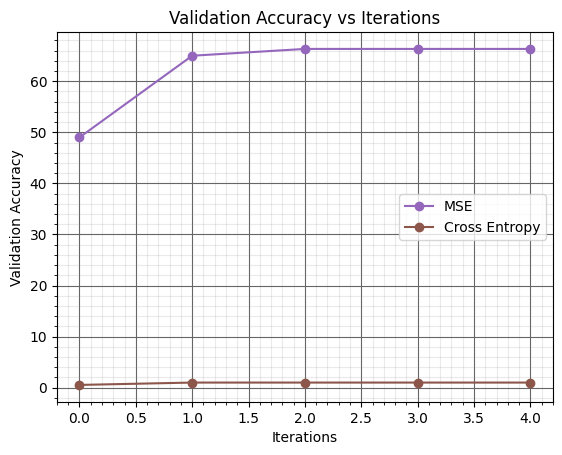

In [50]:
# Plotting validation accuracy vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
x_val_acc = np.arange(len(val_acc_5_mse))
plt.plot(x_val_acc, val_acc_5_mse, label="MSE", color='tab:purple', marker='o')
plt.plot(x_val_acc, val_acc_5_ce, label="Cross Entropy", color='tab:brown', marker='o')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Iterations')
plt.legend()

plt.show()


In [51]:
model_5_mse.eval()
correct_array_mse = np.zeros(20)
correct_array_ce = np.zeros(20)

with torch.no_grad():
    for i in range(len(test_inputs)):
        a = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        a[0] = torch.from_numpy(test_inputs[i])
        output = model_5_mse(a.float())
        label = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0
        correct_array_mse[len(label) - 1] += (predicted == label.float()).sum().item() / (len(label))

    print('Accuracy with MSE Loss:', (np.sum(correct_array_mse) / 20))

model_5_ce.eval()

with torch.no_grad():
    for i in range(len(test_inputs)):
        a = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        a[0] = torch.from_numpy(test_inputs[i])
        output = model_5_ce(a.float())
        label = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output > 0.5] = 1
        predicted[output <= 0.5] = 0
        correct_array_ce[len(label) - 1] += (predicted == label.float()).sum().item() / (len(label))

    print('Accuracy with Cross Entropy Loss:', (np.sum(correct_array_ce) / 20))


Accuracy with MSE Loss: 92.5543105847111
Accuracy with Cross Entropy Loss: 92.5543105847111


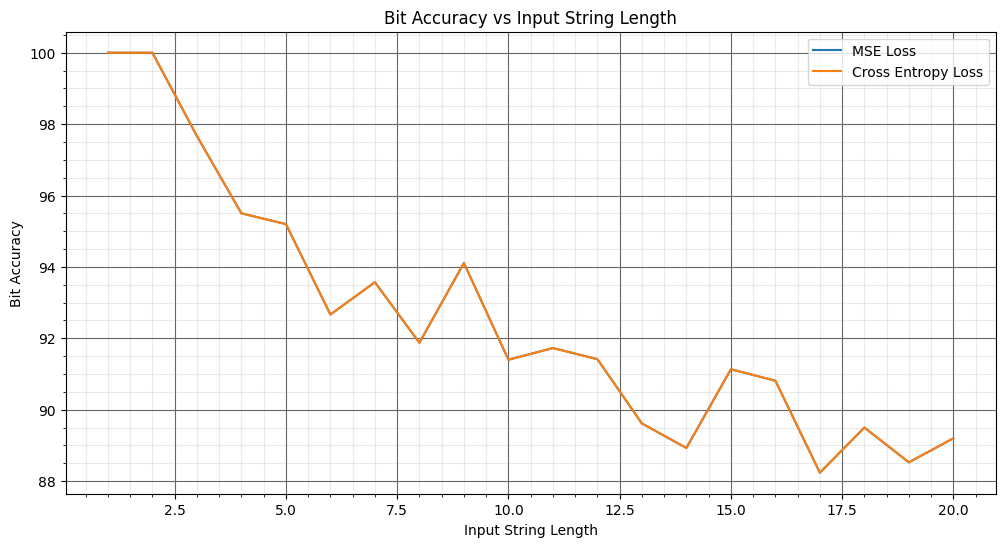

In [52]:
input_lengths = np.arange(1, 21)
plt_accuracy_plot = plt.figure(figsize=(12, 6))
plt.figure(1)
plt.plot(input_lengths, correct_array_mse, label="MSE Loss")
plt.plot(input_lengths, correct_array_ce, label="Cross Entropy Loss")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.show()


# Fixed input lengths: 3, 5, and 10

In [54]:
# generating training data for three different scenarios with fixed input lengths: 3, 5, and 10
train_inputs_3 = []
train_labels_3 = []
for i in range(250):
  input_seq, target_seq = binary_pair_generator(3)
  train_inputs_3.append(input_seq)
  train_labels_3.append(target_seq)

train_inputs_5 = []
train_labels_5 = []
for i in range(250):
  input_seq, target_seq = binary_pair_generator(5)
  train_inputs_5.append(input_seq)
  train_labels_5.append(target_seq)

train_inputs_10 = []
train_labels_10 = []
for i in range(250):
  input_seq, target_seq = binary_pair_generator(10)
  train_inputs_10.append(input_seq)
  train_labels_10.append(target_seq)

In [55]:
learning_rate_new = 0.01
num_epochs = 5

loss_function = nn.MSELoss()

# Initializing models with different hidden state sizes for more variety
model6 = LSTM(5)
model7 = LSTM(5)
model8 = LSTM(5)

# Optimizers for the models
optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate_new)
optimizer7 = torch.optim.Adam(model7.parameters(), lr=learning_rate_new)
optimizer8 = torch.optim.Adam(model8.parameters(), lr=learning_rate_new)


In [56]:
training_loss_3 = []
validation_loss_3 = []
validation_accuracy_3 = []

for epoch in range(epochs):
    for i in range(len(train_inputs_3)):
        input_tensor = torch.zeros((1, train_inputs_3[i].shape[0], train_inputs_3[i].shape[1]))
        input_tensor[0] = torch.from_numpy(train_inputs_3[i])
        output = model6(input_tensor.float())
        target = torch.tensor(np.transpose(train_labels_3[i]))
        loss = loss_function(output, target.float())
        training_loss_3.append(loss.item())

        optimizer6.zero_grad()
        loss.backward()
        optimizer6.step()

    iteration_count = 0
    validation_loss_temp = 0
    correct_val_count = 0

    for i in range(len(val_inputs)):
        correct_predictions = 0
        input_tensor = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(val_inputs[i])
        output = model6(input_tensor.float())
        target = torch.tensor(np.transpose(val_labels[i]))
        loss = loss_function(output, target.float())
        iteration_count += 1
        validation_loss_temp += loss.item()

        predicted_output = torch.zeros(output.shape)
        predicted_output[output >= 0.5] = 1
        predicted_output[output < 0.5] = 0
        correct_predictions += (predicted_output == target.float()).sum().item() / len(target)

    validation_accuracy_3.append(100 * correct_predictions / iteration_count)
    validation_loss_3.append(validation_loss_temp / iteration_count)
    print(f'Epoch [{epoch + 1}/{epochs}] : Training Loss = {training_loss_3[-1]:.4f}, '
          f'Validation Loss = {validation_loss_3[-1]:.4f}, '
          f'Validation Accuracy = {validation_accuracy_3[-1]:.2f}% completed.')


Epoch [1/5] : Training Loss = 0.1849, Validation Loss = 0.2322, Validation Accuracy = 0.46% completed.
Epoch [2/5] : Training Loss = 0.0172, Validation Loss = 0.1607, Validation Accuracy = 0.85% completed.
Epoch [3/5] : Training Loss = 0.0057, Validation Loss = 0.1630, Validation Accuracy = 0.85% completed.
Epoch [4/5] : Training Loss = 0.0033, Validation Loss = 0.1681, Validation Accuracy = 0.85% completed.
Epoch [5/5] : Training Loss = 0.0014, Validation Loss = 0.2119, Validation Accuracy = 0.77% completed.


In [57]:
training_loss_5 = []
validation_loss_5 = []
validation_accuracy_5 = []

for epoch in range(epochs):
    for i in range(len(train_inputs_5)):
        input_tensor = torch.zeros((1, train_inputs_5[i].shape[0], train_inputs_5[i].shape[1]))
        input_tensor[0] = torch.from_numpy(train_inputs_5[i])
        output = model7(input_tensor.float())
        target = torch.tensor(np.transpose(train_labels_5[i]))
        loss = loss_function(output, target.float())
        training_loss_5.append(loss.item())

        optimizer7.zero_grad()
        loss.backward()
        optimizer7.step()

    iteration_count = 0
    validation_loss_temp = 0
    correct_predictions = 0

    for i in range(len(val_inputs)):
        input_tensor = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(val_inputs[i])
        output = model7(input_tensor.float())
        target = torch.tensor(np.transpose(val_labels[i]))
        loss = loss_function(output, target.float())
        iteration_count += 1
        validation_loss_temp += loss.item()

        predicted_output = torch.zeros(output.shape)
        predicted_output[output >= 0.5] = 1
        predicted_output[output < 0.5] = 0
        correct_predictions += (predicted_output == target.float()).sum().item() / len(target)

    validation_accuracy.append(100 * correct_predictions / iteration_count)
    validation_loss.append(validation_loss_temp / iteration_count)
    print(f'Epoch [{epoch + 1}/{epochs}] : Training Loss = {training_loss[-1]:.4f}, '
          f'Validation Loss = {validation_loss[-1]:.4f}, '
          f'Validation Accuracy = {validation_accuracy[-1]:.2f}% completed.')


Epoch [1/5] : Training Loss = 0.0956, Validation Loss = 0.2090, Validation Accuracy = 80.42% completed.
Epoch [2/5] : Training Loss = 0.0956, Validation Loss = 0.0959, Validation Accuracy = 85.24% completed.
Epoch [3/5] : Training Loss = 0.0956, Validation Loss = 0.0489, Validation Accuracy = 89.57% completed.
Epoch [4/5] : Training Loss = 0.0956, Validation Loss = 0.0289, Validation Accuracy = 100.00% completed.
Epoch [5/5] : Training Loss = 0.0956, Validation Loss = 0.0188, Validation Accuracy = 100.00% completed.


In [59]:
training_loss_10 = []
validation_loss_10 = []
validation_accuracy_10 = []

for epoch in range(epochs):
    for i in range(len(train_inputs_10)):
        input_tensor = torch.zeros((1, train_inputs_10[i].shape[0], train_inputs_10[i].shape[1]))
        input_tensor[0] = torch.from_numpy(train_inputs_10[i])
        output = model8(input_tensor.float())
        target = torch.tensor(np.transpose(train_labels_10[i]))
        loss = loss_function(output, target.float())
        training_loss_10.append(loss.item())

        optimizer8.zero_grad()
        loss.backward()
        optimizer8.step()

    iteration_count = 0
    validation_loss_temp = 0
    correct_predictions = 0

    for i in range(len(val_inputs)):
        input_tensor = torch.zeros((1, val_inputs[i].shape[0], val_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(val_inputs[i])
        output = model8(input_tensor.float())
        target = torch.tensor(np.transpose(val_labels[i]))
        loss = loss_function(output, target.float())
        iteration_count += 1
        validation_loss_temp += loss.item()

        predicted_output = torch.zeros(output.shape)
        predicted_output[output >= 0.5] = 1
        predicted_output[output < 0.5] = 0
        correct_predictions += (predicted_output == target.float()).sum().item() / len(target)

    validation_accuracy_10.append(100 * correct_predictions / iteration_count)
    validation_loss_10.append(validation_loss_temp / iteration_count)
    print(f'Epoch [{epoch + 1}/{epochs}] : Training Loss = {training_loss_10[-1]:.4f}, '
          f'Validation Loss = {validation_loss_10[-1]:.4f}, '
          f'Validation Accuracy = {validation_accuracy_10[-1]:.2f}% completed.')


Epoch [1/5] : Training Loss = 0.2489, Validation Loss = 0.2459, Validation Accuracy = 60.69% completed.
Epoch [2/5] : Training Loss = 0.1438, Validation Loss = 0.1147, Validation Accuracy = 91.21% completed.
Epoch [3/5] : Training Loss = 0.0529, Validation Loss = 0.0291, Validation Accuracy = 99.83% completed.
Epoch [4/5] : Training Loss = 0.0142, Validation Loss = 0.0086, Validation Accuracy = 100.00% completed.
Epoch [5/5] : Training Loss = 0.0066, Validation Loss = 0.0042, Validation Accuracy = 100.00% completed.


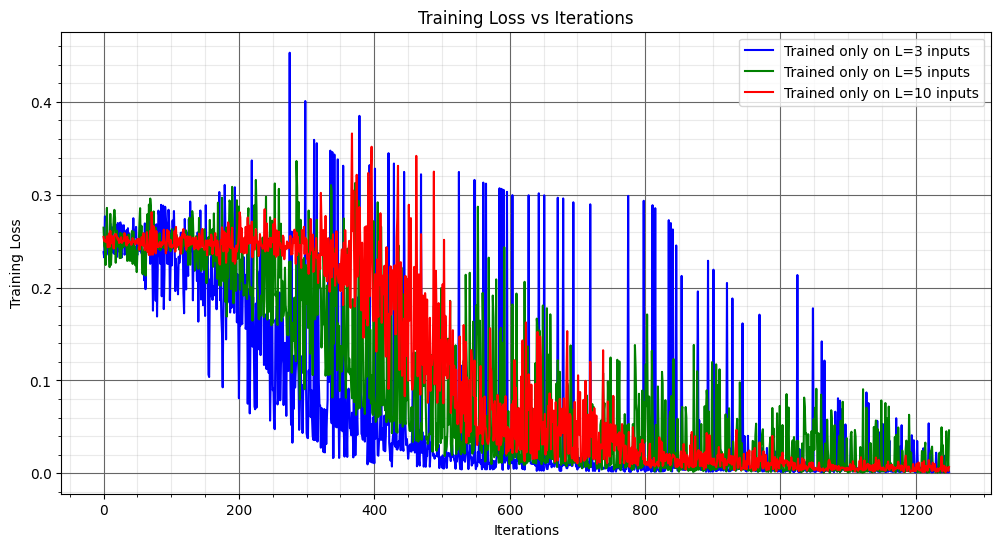

In [60]:
# Plotting training loss vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(1)
x_train_loss = np.arange(len(training_loss_3))
plt.plot(x_train_loss, training_loss_3, label="Trained only on L=3 inputs", color='blue')
plt.plot(x_train_loss, training_loss_5, label="Trained only on L=5 inputs", color='green')
plt.plot(x_train_loss, training_loss_10, label="Trained only on L=10 inputs", color='red')
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

In [ ]:
# Plotting validation loss vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(2)
x_val_loss = np.arange(len(validation_loss_3))
plt.plot(x_val_loss, validation_loss_3, label="Trained only on L=3 inputs", color='blue')
plt.plot(x_val_loss, validation_loss_5, label="Trained only on L=5 inputs", color='green')
plt.plot(x_val_loss, validation_loss_10, label="Trained only on L=10 inputs", color='red')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')
plt.legend()

In [ ]:
# Plotting validation accuracy vs iterations
plt_1 = plt.figure(figsize=(12, 6))
plt.figure(3)
x_val_acc = np.arange(len(validation_accuracy_3))
plt.plot(x_val_acc, validation_accuracy_3, label="Trained only on L=3 inputs", color='blue')
plt.plot(x_val_acc, validation_accuracy_5, label="Trained only on L=5 inputs", color='green')
plt.plot(x_val_acc, validation_accuracy_10, label="Trained only on L=10 inputs", color='red')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Iterations')
plt.legend()

plt.show()


In [63]:
model6.eval()
bit_accuracy_6 = np.zeros(20)
bit_accuracy_7 = np.zeros(20)
bit_accuracy_8 = np.zeros(20)

with torch.no_grad():
    for i in range(len(test_inputs)):
        input_tensor = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(test_inputs[i])
        output = model6(input_tensor.float())
        target = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output >= 0.5] = 1
        predicted[output < 0.5] = 0
        bit_accuracy_6[len(target) - 1] += (predicted == target.float()).sum().item() / len(target)

    print('Accuracy when trained on L=3 inputs:', (np.sum(bit_accuracy_6) / 20))

model7.eval()
with torch.no_grad():
    for i in range(len(test_inputs)):
        input_tensor = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(test_inputs[i])
        output = model7(input_tensor.float())
        target = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output > 0.5] = 1
        predicted[output <= 0.5] = 0
        bit_accuracy_7[len(target) - 1] += (predicted == target.float()).sum().item() / len(target)

    print('Accuracy when trained on L=5 inputs:', (np.sum(bit_accuracy_7) / 20))

model8.eval()
with torch.no_grad():
    for i in range(len(test_inputs)):
        input_tensor = torch.zeros((1, test_inputs[i].shape[0], test_inputs[i].shape[1]))
        input_tensor[0] = torch.from_numpy(test_inputs[i])
        output = model8(input_tensor.float())
        target = torch.tensor(np.transpose(test_labels[i]))
        predicted = torch.zeros(output.shape)
        predicted[output > 0.5] = 1
        predicted[output <= 0.5] = 0
        bit_accuracy_8[len(target) - 1] += (predicted == target.float()).sum().item() / len(target)

    print('Accuracy when trained on L=10 inputs:', (np.sum(bit_accuracy_8) / 20))


Accuracy when trained on L=3 inputs: 73.94330496795087
Accuracy when trained on L=5 inputs: 100.0
Accuracy when trained on L=10 inputs: 100.0


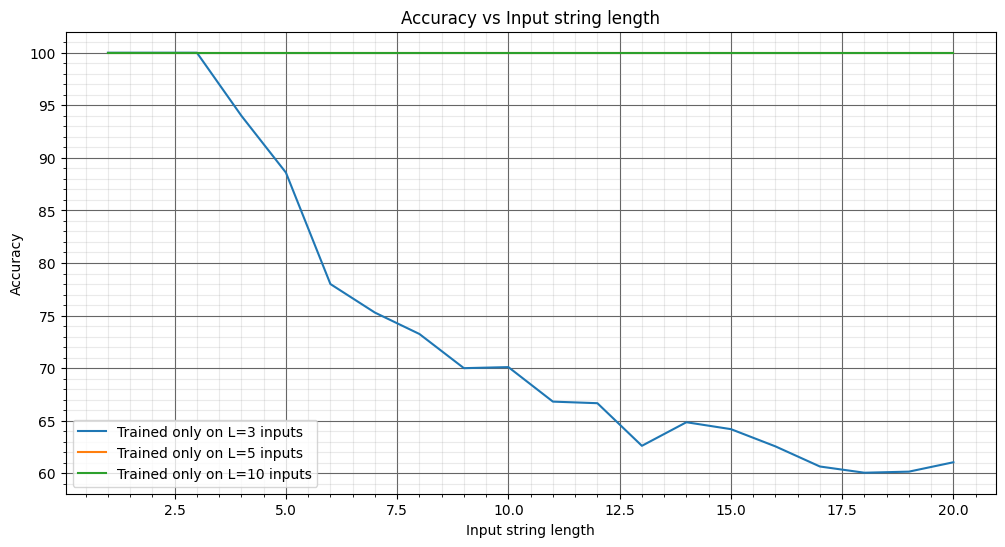

In [64]:
bit_length_range = np.arange(1,21)
plt_1 = plt.figure(figsize=(12,6))
plt.figure(1)
plt.plot(bit_length_range, bit_accuracy_6, label="Trained only on L=3 inputs")
plt.plot(bit_length_range, bit_accuracy_7, label="Trained only on L=5 inputs")
plt.plot(bit_length_range, bit_accuracy_8, label="Trained only on L=10 inputs")
plt.grid(which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input string length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input string length')
plt.legend()
plt.show()